### 퍼스널컬러 개인화 팔레트 색상 추출
    
    최초 작성일 : 20/02/23
    작성자 : 김은주
    
    작성내용 : palette_bright & palette_harmony
               -> 퍼스널컬러 타입 별 개인화 퍼스널컬러 & 하모니컬러 팔레트 추출
               -> (color_convert_test) 개인 스킨톤 HSV값 추출
               -> 스킨톤에 따른 개인화 팔레트 각 6개 컬러(hsv) 팔레트 리턴
               
               select_prdt_color
               -> DB 상품이미지 HSV정보 값 조회
               -> 현 DB 색정보 컬럼 수 xxxxx개
               
               matchedPrdt
               -> 개인화 컬러팔레트에 맞는 상품(select_prdt_color 조회 값) 매칭
               -> 색매칭 오차범위 변수 설정
               -> 매칭되는 값이 없을경우 예외처리
               -> fancy indexing으로 상품코드 추출
               
               getPrdtimage
               -> 웹 구현용 매칭 상품(matchedPrdt) 이미지링크 조회
               
               to_rgb
               -> 웹 구현용 rgb 변환
               
               show_color
               -> 색 확인용 코드 작성

    수정내용 
        20/03/06
               개인화 팔레트 시각화
               -> 개인화 팔레트 추출 색 시각화 함수 작성
               팔레트-상품 색 매칭 & 코드추출
               -> 팔레트 매칭용 HSV 샘플 생성
               -> 팔레트 매칭 색 오차범위 설정
               -> HSV 오차범위 조건, fancy indexing
               -> 팔레트 매칭된 상품코드 추출
               팔레트 추출/시각화/상품추출 함수 통합실행으로 수정

        20/03/07
               코드 수정
               -> 오차범위 내 매칭 상품이 없을 경우 처리
               -> 매칭상품 색 시각화 오류 수정
               팔레트 추출, 상품매칭 클래스로 작성
               
        20/04/02
               조화색 팔레트 추출 함수 추가 작성
               매칭 상품 상품코드 추출 코드 작성
               웹페이지용 rgb 팔레트 함수 추가

        20/04/03
               PRDT_IMAGE 테이블 상품 색정보 조회 함수 작성
               웹용 이미지링크 조회 함수 추가
               오류 수정
               -> 매칭 상품 수 6개 제한 시 발생 오류 수정
               
        20/04/04
               오류 수정
               -> 매칭 상품 수 6개 제한 시 발생 오류 수정

In [1]:
# pip install colour-science
# pip install opencv-python
import requests, pymysql, math, re, time
import pandas as pd
import numpy as np
from PIL import Image

import cv2 as cv
import colour

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
font_name = fm.FontProperties(fname='C:\Windows/Fonts/malgun.ttf').get_name()
plt.rc('font', family=font_name)
mpl.rcParams["axes.unicode_minus"] = False
from matplotlib.colors import hsv_to_rgb

In [2]:
# 퍼스널컬러 팔레트 매칭 함수
def palette_bright(person_HSV):
    # 입력값 Hue, Sturation, Value에 따라 변수 지정
    H = float(person_HSV[0])
    S = float(person_HSV[1])
    V = float(person_HSV[2])
    diff = round(V - S, 2)    
    
    # (보색, 삼각보색1, 삼각보색2, 이중보색1, 이중보색2, 이중보색3)
    # hue 변경 값
    h_warm_plus, h_cool_plus = [175, 30, 330, 50, 180, 230], [185, 150, 210, 130, 180, 310]
    # saturation 변경 값
    s_SpringWinter_plus, s_SummerAutumn_plus = [40, 10, 30, 50, 45, 50], [0, -30, -10, 10, 5, 10]
    # Value 변경 값
    v_SpringWinter_plus, v_SummerAutumn_plus = [-40, -15, -30, -40, -15, -40], [-20, 5, -10, -20, 5, -20]
    # 각 보색 값 변수
    h_list, s_list, v_list = [], [], []
    
    try:
        # 웜톤
        if H >= 23 and H <= 203 : 
            # 웜톤 HUE 변경
            for hue, i in zip(h_warm_plus, range(6)):
                if H+hue <= 359:
                    h_list.append(H+h_warm_plus[i])
                else:
                    h_list.append(H+h_warm_plus[1]-359)

            # 봄
            if diff >= 43.15 :
                for saturation, value, i in zip(s_SpringWinter_plus, v_SpringWinter_plus, range(6)):
                    # Saturation
                    if saturation >= 0:                    
                        if S+saturation <= 100:
                            s_list.append(S+s_SpringWinter_plus[i])
                        else:
                            s_list.append(S-s_SpringWinter_plus[i])
                    else:
                        if S+saturation >= 10:
                            s_list.append(S+s_SpringWinter_plus[i])
                        else:
                            s_list.append(S-s_SpringWinter_plus[i])
                    # Vlaue
                    if value >= 0:                    
                        if V+value <= 100:
                            v_list.append(V+v_SpringWinter_plus[i])
                        else:
                            v_list.append(V-v_SpringWinter_plus[i])
                    else:
                        if V+saturation >= 10:
                            v_list.append(V+v_SpringWinter_plus[i])
                        else:
                            v_list.append(V-v_SpringWinter_plus[i])                    

            # 가을
            elif diff <= 43.15:
                for saturation, value, i in zip(s_SummerAutumn_plus, v_SummerAutumn_plus, range(6)):
                    if saturation >= 0:                    
                        if S+saturation <= 100:
                            s_list.append(S+s_SummerAutumn_plus[i])
                        else:
                            s_list.append(S-s_SummerAutumn_plus[i])
                    else:
                        if S+saturation >= 10:
                            s_list.append(S+s_SummerAutumn_plus[i])
                        else:
                            s_list.append(S-s_SummerAutumn_plus[i])

                    if value >= 0:                    
                        if V+value <= 100:
                            v_list.append(V+v_SummerAutumn_plus[i])
                        else:
                            v_list.append(V-v_SummerAutumn_plus[i])
                    else:
                        if V+saturation >= 10:
                            v_list.append(V+v_SummerAutumn_plus[i])
                        else:
                            v_list.append(V-v_SummerAutumn_plus[i])

        # 쿨톤
        elif (H >= 0 and H < 23) or (H > 203 and H <= 360) :
            # 쿨톤 HUE 변경
            for hue, i in zip(h_cool_plus, range(6)):
                if H+hue <= 359:
                    h_list.append(H+h_cool_plus[i])
                else:
                    h_list.append(H+h_cool_plus[1]-359)

            # 여름
            if diff >= 47.15 :
                for saturation, value, i in zip(s_SummerAutumn_plus, v_SummerAutumn_plus, range(6)):
                    if saturation >= 0:                    
                        if S+saturation <= 100:
                            s_list.append(S+s_SummerAutumn_plus[i])
                        else:
                            s_list.append(S-s_SummerAutumn_plus[i])
                    else:
                        if S+saturation >= 10:
                            s_list.append(S+s_SummerAutumn_plus[i])
                        else:
                            s_list.append(S-s_SummerAutumn_plus[i])

                    if value >= 0:                    
                        if V+value <= 100:
                            v_list.append(V+v_SummerAutumn_plus[i])
                        else:
                            v_list.append(V-v_SummerAutumn_plus[i])
                    else:
                        if V+saturation >= 10:
                            v_list.append(V+v_SummerAutumn_plus[i])
                        else:
                            v_list.append(V-v_SummerAutumn_plus[i])

            # 겨울
            elif diff <= 47.15:
                for saturation, value, i in zip(s_SpringWinter_plus, v_SpringWinter_plus, range(6)):
                    # Saturation
                    if saturation >= 0:                    
                        if S+saturation <= 100:
                            s_list.append(S+s_SpringWinter_plus[i])
                        else:
                            s_list.append(S-s_SpringWinter_plus[i])
                    else:
                        if S+saturation >= 10:
                            s_list.append(S+s_SpringWinter_plus[i])
                        else:
                            s_list.append(S-s_SpringWinter_plus[i])
                    # Vlaue
                    if value >= 0:                    
                        if V+value <= 100:
                            v_list.append(V+v_SpringWinter_plus[i])
                        else:
                            v_list.append(V-v_SpringWinter_plus[i])
                    else:
                        if V+saturation >= 10:
                            v_list.append(V+v_SpringWinter_plus[i])
                        else:
                            v_list.append(V-v_SpringWinter_plus[i])                    

        else :
            h_list, s_list, v_list = [0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0]
    
    except:
        print('팔레트 매칭에서 오류발생')
    
    # 팔레트 HSV
    comp_color = [h_list[0], s_list[0], v_list[0]]
    triangle_comp_color_1 = [h_list[1], s_list[1], v_list[1]]
    triangle_comp_color_2 = [h_list[2], s_list[2], v_list[2]]
    doubleness_comp_color_1 = [h_list[3], s_list[3], v_list[3]]
    doubleness_comp_color_2 = [h_list[4], s_list[4], v_list[4]]
    doubleness_comp_color_3 = [h_list[5], s_list[5], v_list[5]]
    
    personalization_palette = [comp_color, triangle_comp_color_1, triangle_comp_color_2, 
                              doubleness_comp_color_1, doubleness_comp_color_2, doubleness_comp_color_3]
    
    return personalization_palette

In [3]:
# 조화색 팔레트 매칭 함수
def palette_harmony(person_HSV):
    # 입력값 Hue, Sturation, Value에 따라 변수 지정
    H = float(person_HSV[0])
    S = float(person_HSV[1])
    V = float(person_HSV[2])
    diff = round(V - S, 2)    
    
    # (보색, 삼각보색1, 삼각보색2, 이중보색1, 이중보색2, 이중보색3)
    # hue 변경 값
    h_warm_plus, h_cool_plus = [247, 102, 42, 122, 252, 302], [257, 222, 282, 202, 252, 22]
    # saturation 변경 값
    s_SpringWinter_plus, s_SummerAutumn_plus = [40, 10, 30, 50, 45, 50], [0, -30, -10, 10, 5, 10]
    # Value 변경 값
    v_SpringWinter_plus, v_SummerAutumn_plus = [-40, -15, -30, -40, -15, -40], [-20, 5, -10, -20, 5, -20]
    # 각 보색 값 변수
    h_list, s_list, v_list = [], [], []
    
    try:
        # 웜톤
        if H >= 23 and H <= 203 : 
            # 웜톤 HUE 변경
            for hue, i in zip(h_warm_plus, range(6)):
                if H+hue <= 359:
                    h_list.append(H+h_warm_plus[i])
                else:
                    h_list.append(H+h_warm_plus[1]-359)

            # 봄
            if diff >= 43.15 :
                for saturation, value, i in zip(s_SpringWinter_plus, v_SpringWinter_plus, range(6)):
                    # Saturation
                    if saturation >= 0:                    
                        if S+saturation <= 100:
                            s_list.append(S+s_SpringWinter_plus[i])
                        else:
                            s_list.append(S-s_SpringWinter_plus[i])
                    else:
                        if S+saturation >= 10:
                            s_list.append(S+s_SpringWinter_plus[i])
                        else:
                            s_list.append(S-s_SpringWinter_plus[i])
                    # Vlaue
                    if value >= 0:                    
                        if V+value <= 100:
                            v_list.append(V+v_SpringWinter_plus[i])
                        else:
                            v_list.append(V-v_SpringWinter_plus[i])
                    else:
                        if V+saturation >= 10:
                            v_list.append(V+v_SpringWinter_plus[i])
                        else:
                            v_list.append(V-v_SpringWinter_plus[i])                    

            # 가을
            elif diff <= 43.15:
                for saturation, value, i in zip(s_SummerAutumn_plus, v_SummerAutumn_plus, range(6)):
                    if saturation >= 0:                    
                        if S+saturation <= 100:
                            s_list.append(S+s_SummerAutumn_plus[i])
                        else:
                            s_list.append(S-s_SummerAutumn_plus[i])
                    else:
                        if S+saturation >= 10:
                            s_list.append(S+s_SummerAutumn_plus[i])
                        else:
                            s_list.append(S-s_SummerAutumn_plus[i])

                    if value >= 0:                    
                        if V+value <= 100:
                            v_list.append(V+v_SummerAutumn_plus[i])
                        else:
                            v_list.append(V-v_SummerAutumn_plus[i])
                    else:
                        if V+saturation >= 10:
                            v_list.append(V+v_SummerAutumn_plus[i])
                        else:
                            v_list.append(V-v_SummerAutumn_plus[i])

        # 쿨톤
        elif (H >= 0 and H < 23) or (H > 203 and H <= 360) :
            # 쿨톤 HUE 변경
            for hue, i in zip(h_cool_plus, range(6)):
                if H+hue <= 359:
                    h_list.append(H+h_cool_plus[i])
                else:
                    h_list.append(H+h_cool_plus[1]-359)

            # 여름
            if diff >= 47.15 :
                for saturation, value, i in zip(s_SummerAutumn_plus, v_SummerAutumn_plus, range(6)):
                    if saturation >= 0:                    
                        if S+saturation <= 100:
                            s_list.append(S+s_SummerAutumn_plus[i])
                        else:
                            s_list.append(S-s_SummerAutumn_plus[i])
                    else:
                        if S+saturation >= 10:
                            s_list.append(S+s_SummerAutumn_plus[i])
                        else:
                            s_list.append(S-s_SummerAutumn_plus[i])

                    if value >= 0:                    
                        if V+value <= 100:
                            v_list.append(V+v_SummerAutumn_plus[i])
                        else:
                            v_list.append(V-v_SummerAutumn_plus[i])
                    else:
                        if V+saturation >= 10:
                            v_list.append(V+v_SummerAutumn_plus[i])
                        else:
                            v_list.append(V-v_SummerAutumn_plus[i])

            # 겨울
            elif diff <= 47.15:
                for saturation, value, i in zip(s_SpringWinter_plus, v_SpringWinter_plus, range(6)):
                    # Saturation
                    if saturation >= 0:                    
                        if S+saturation <= 100:
                            s_list.append(S+s_SpringWinter_plus[i])
                        else:
                            s_list.append(S-s_SpringWinter_plus[i])
                    else:
                        if S+saturation >= 10:
                            s_list.append(S+s_SpringWinter_plus[i])
                        else:
                            s_list.append(S-s_SpringWinter_plus[i])
                    # Vlaue
                    if value >= 0:                    
                        if V+value <= 100:
                            v_list.append(V+v_SpringWinter_plus[i])
                        else:
                            v_list.append(V-v_SpringWinter_plus[i])
                    else:
                        if V+saturation >= 10:
                            v_list.append(V+v_SpringWinter_plus[i])
                        else:
                            v_list.append(V-v_SpringWinter_plus[i])                    

        else :
            h_list, s_list, v_list = [0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0]
    
    except:
        print('팔레트 매칭에서 오류발생')
    
    # 팔레트 HSV
    comp_color = [h_list[0], s_list[0], v_list[0]]
    triangle_comp_color_1 = [h_list[1], s_list[1], v_list[1]]
    triangle_comp_color_2 = [h_list[2], s_list[2], v_list[2]]
    doubleness_comp_color_1 = [h_list[3], s_list[3], v_list[3]]
    doubleness_comp_color_2 = [h_list[4], s_list[4], v_list[4]]
    doubleness_comp_color_3 = [h_list[5], s_list[5], v_list[5]]
    
    personalization_palette = [comp_color, triangle_comp_color_1, triangle_comp_color_2, 
                              doubleness_comp_color_1, doubleness_comp_color_2, doubleness_comp_color_3]
    
    return personalization_palette

In [5]:
# DB 상품코드별 색 정보 가져오기
def select_prdt_color(cursor):
    sql = "SELECT H, S, V, PRDT_CODE FROM PRDT_IMAGE WHERE H is NOT NULL;"
    cursor.execute(sql)
    
    prdt_hsv = pd.DataFrame(cursor, columns=["H", "S", "V", "PRDT_CODE"])
    
    cols = ["H", "S", "V"]
    for col in cols:
        prdt_hsv[col] = prdt_hsv[col].astype(float)

    HSV = np.array(prdt_hsv).reshape(1, -1, 4)
    
    return HSV

In [5]:
# 팔레트 추출값에 색매칭 상품코드 추출
def matched_prdt(personal_palette, HSV):
    try:
        error_range = [5, 5, 5] # 색매칭 오차범위 변수담기
        matched_prdt = [] # 팔레트 총 추천상품 담을 변수

        for i in range(len(personal_palette)):
            prdt_codes = [] # 팔레트별 추출 상품코드 담을 변수
            h, s, v = personal_palette[i][0], personal_palette[i][1], personal_palette[i][2]

            # 오차범위 반영 fancy index 변수로 담기
            H_idx = (HSV[:, :, 0]<(h+error_range[0]))&(HSV[:, :, 0]>(h-error_range[0]))
            S_idx = (HSV[:, :, 1]<(s+error_range[1]))&(HSV[:, :, 1]>(s-error_range[1]))
            V_idx = (HSV[:, :, 2]<(v+error_range[2]))&(HSV[:, :, 2]>(v-error_range[2]))

            # 매칭되는 값이 없을경우 예외처리
            if HSV[(H_idx&S_idx&V_idx)].shape[0] == 0:
                prdt_codes.append("error:no matched product")
            else:
                # fancy indexing으로 상품코드 찾기
                if len(prdt_codes) <= 6:
                    for j in range(HSV[(H_idx&S_idx&V_idx)].shape[0]):
                        prdt_codes.append(HSV[(H_idx&S_idx&V_idx)][:,3][j])
                else:
                    break

            matched_prdt.append(prdt_codes)

        ## 리턴할 상품개수 6개로 제한
        prdt_list = [] # 상품코드 담을 변수
        cnt = 0
        while len(prdt_list) < 6:
            if len(prdt_list) == 6:
                break
            for i in range(len(matched_prdt)):
                if len(prdt_list) == 6:
                    break
                elif matched_prdt[i][0] == "error:no matched product":
                    pass
                elif cnt < len(matched_prdt[i]):
                    prdt_list.append(matched_prdt[i][cnt])
            cnt += 1
                    
    except:
        print('상품추출에서 오류발생')
        
    return prdt_list

In [6]:
# DB 상품 이미지링크 갖고오기
def getPrdtimage(cursor, prdt_code):
    imgLink_list = []
    
    for code in prdt_code:
        sql = "SELECT PRDT_IMG_LINK FROM PRDT_IMAGE WHERE PRDT_CODE = '{}';"
        cursor.execute(sql.format(str(code)))
        
        link = str(cursor.fetchone()).replace("('", "").replace("',)", "")
        imgLink_list.append(link)

    return imgLink_list

In [6]:
# 팔레트 일괄 rgb로 변환 함수
def to_rgb(personal_palette):
    try:
        rgb_palette = []
        for i in range(len(personal_palette)):
            h, s, v = personal_palette[i]
            RGB = hsv_to_rgb(np.array([[[h/359, s/100, v/100]]]))
            rgb_palette.append(list(np.round(RGB*255,0).reshape(3)))
        
    except:
        print('RGB변환에서 오류발생')
        
    return rgb_palette

In [3]:
# 컬러 시각화 함수
def show_colors(personal_palette):
    try:
        rows, cols, cnt = 1, len(personal_palette), 1
        fig = plt.figure(figsize=(12, 3))

        for i in range(len(personal_palette)):
            h, s, v = personal_palette[i]
            RGB = hsv_to_rgb(np.array([[[h/359, s/100, v/100]]]))

            # 시각화
            ax = fig.add_subplot(rows, cols, cnt)
            ax.imshow(RGB)
            ax.set_title(i)
            ax.set_xticks([]), ax.set_yticks([])
            cnt += 1

        plt.show()
        
    except:
        print('팔레트 시각화에서 오류발생')

In [ ]:
## 함수 실행코드

# DB 연결
config = {"host":"49.142.181.65", "user":"cai", "passwd":"1234", "db":"final"}
conn = pymysql.connect(**config)
cursor = conn.cursor()

# PRDT_IMAGE 테이블에 H, S, V, 상품코드 조회
HSV_sample = select_prdt_color(cursor)


# 얼굴 측색값 기준 팔레트 추출 : 각 6개 색 추출
##### 얼굴 측색결과 hsv(359,100,100)#####
hsv = [27, 45, 80]
#########################################

hsv_palette_bright = palette_bright(hsv)
hsv_palette_harmony = palette_harmony(hsv)


# 웹용 팔레트 RGB 변환 : 각 6개 색
rgb_palette_bright = to_rgb(hsv_palette_bright)
rgb_palette_harmony = to_rgb(hsv_palette_harmony)


# 팔레트 컬러 상품 매칭 : 각 상품코드 6개
prdtCode_bright = matched_prdt(hsv_palette_bright)
prdtCode_harmony = matched_prdt(hsv_palette_harmony)


# 상품 이미지링크 갖고오기 : 웹페이지 노출용 이미지링크 각 6개
imgLink_bright = getPrdtimage(cursor, prdtCode_bright)
imgLink_harmony = getPrdtimage(cursor, prdtCode_harmony)


# 내용 확인용
show_colors(hsv_palette_bright)
print(rgb_palette_bright)
print(prdtCode_bright)
print(imgLink_bright)

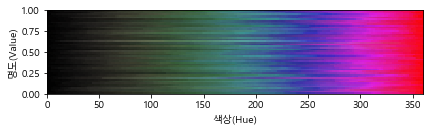

In [12]:
# # 팔레트-상품 색 매칭 & 코드추출 테스트
# ############################################################ 색매칭용 HSV 샘플 생성
# x, y = 50, 150
# np.random.seed(0)
# H = np.random.randint(0, 359, size=(x, y))
# S = np.random.randint(1, 99, size=(x, y))
# V = np.random.randint(1, 99, size=(x, y))
# CODE = np.random.randint(100000, 999999, size=(x, y))

# HSV_sample = np.dstack((H, S, V, CODE))
# ############################################################

# ############################## 색매칭용 HSV 샘플 생성
# x, y = 50, 200
# np.random.seed(0)
# H = np.random.randint(0, 359, size=(x, y))
# S = np.random.randint(1, 99, size=(x, y))
# V = np.random.randint(1, 99, size=(x, y))
# CODE = np.random.randint(100000, 999999, size=(x, y))

# HSV_sample = np.dstack((H, S, V, CODE))
# ##############################

# ############################## HSV 샘플 색 시각화
# HSV_sample = np.dstack((H/359, S/100, V/100, CODE))
# RGB = hsv_to_rgb(HSV_sample[:, :, :3])

# plt.subplot(211)
# plt.imshow(RGB, origin="lower", extent=[0, 360, 0, 1], aspect=80)
# plt.xlabel("색상(Hue)")
# plt.ylabel("명도(Value)")
# plt.grid(False)

# plt.tight_layout()
# plt.show()
# ##############################

# ############################## HSV 샘플 데이터 파악
# HSV_sample[:, :, 0] # H
# HSV_sample[:, :, 1] # s
# HSV_sample[:, :, 2] # V
# HSV_sample[:, :, :3] # HSV
# HSV_sample[:, :, 3] # CODE

# HSV_sample[0, :, :].shape # 0~69 : (300, 4)
# HSV_sample[:, 0, :].shape # 0~299 : (70, 4)
# HSV_sample[:, :, 0].shape # 0~3 : (70, 300)
# ##############################

# ############################## HSV 샘플에서 색 매칭 상품코드 찾기
# """
# 무신사 상품이미지 측색 데이터 DB에 저장되면
# 나중에 
# HSV_sample = np.dstack((H, S, V, CODE))
# 요런 형태로 끌어올 수 있게 코딩
# ↓↓↓↓↓아래처럼 찾아오긔↓↓↓↓↓
# """
# # 오차범위 설정
# ### 오차범위 숫자들은 변수로 담아서 수식으로 넣기 (아래는 테스트용)
# H_idx = (HSV_sample[:, :, 0]<165)&(HSV_sample[:, :, 0]>160)
# S_idx = (HSV_sample[:, :, 1]<45)&(HSV_sample[:, :, 1]>35)
# V_idx = (HSV_sample[:, :, 2]<45)&(HSV_sample[:, :, 2]>35)

# # HSV 오차범위 조건으로 팬시인덱싱, 데이터 확인
# HSV_sample[(H_idx&S_idx&V_idx)]      # fancy indexing
# HSV_sample[(H_idx&S_idx&V_idx)][:,0] # H
# HSV_sample[(H_idx&S_idx&V_idx)][:,1] # S
# HSV_sample[(H_idx&S_idx&V_idx)][:,2] # V
# HSV_sample[(H_idx&S_idx&V_idx)][:,3] # CODE

# # fancy indexing으로 상품코드 찾기
# for i in range(HSV_sample[(H_idx&S_idx&V_idx)].shape[0]): 
#     print(i+1,"번째 매칭 상품", HSV_sample[(H_idx&S_idx&V_idx)][:,3][i])

# # np.where 로 상품코드 찾기
# for i in range(HSV_sample[(H_idx&S_idx&V_idx)].shape[0]):
#     prdt_idx1, prdt_idx2 = np.where(HSV_sample[(H_idx&S_idx&V_idx)][:,3][i] == HSV_sample[:, :, 3])
#     prdt_code = HSV_sample[:, :, 3][prdt_idx1[0], prdt_idx2[0]]
#     print("{}번째 매칭 상품 {}".format(i, prdt_code))
# ##############################
# "희희"